In [149]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,
                             mean_absolute_error, mean_squared_error, root_mean_squared_error, r2_score, roc_auc_score,
                             roc_curve)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [150]:
df = pd.read_csv('data/fifa_players_preprocessed.csv')

In [151]:
n_features = [
    'overall', 'height_cm', 'weight_kg', 'weak_foot', 'skill_moves',
    'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic',
    'potential', 'height_weight_ratio', 'primary_position_enc'
]

In [152]:
c_features = [col for col in df.columns if
              col.startswith("work_rate_") or col.startswith("preferred_foot_") or col.startswith("age_group_")]

features = n_features + c_features
X = df[features]
y_clf = df["high_value"]
scaler = StandardScaler()
X[n_features] = scaler.fit_transform(X[n_features])

C:\Users\user\AppData\Local\Temp\ipykernel_29132\4017860778.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[n_features] = scaler.fit_transform(X[n_features])


In [153]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

In [154]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_clf, test_size=0.2, random_state=2500, stratify=y_clf
)

In [155]:
param_grid = {
    "max_depth": [3, 5, 7, 9, None],
    "min_samples_split": [2, 5, 10, 20],
    "min_samples_leaf": [1, 2, 4, 8],
    "criterion": ["gini", "entropy"]
}

In [156]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
dt.score(X_test, y_test)

0.9793922458959133

In [157]:
grid_dt = GridSearchCV(dt, param_grid, cv=5, return_train_score=False)
grid_dt.fit(X_train, y_train)

,estimator,DecisionTreeC...ndom_state=42)
,param_grid,"{'criterion': ['gini', 'entropy'], 'max_depth': [3, 5, ...], 'min_samples_leaf': [1, 2, ...], 'min_samples_split': [2, 5, ...]}"
,scoring,None
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,criterion,'entropy'


__Logistic Regression was 90% which means for Decision Tree using default hyperparameters increased value up to 1,4% and with best parameters up to 2,2%__

__It was before I added simple yet important feature which is 'Overall' column. This means that this additional column made our model understand the rule of applying prices to our Players which got our Logistic Regression up to 96% and Decision tree 98.1% with default hyperparameters and 98.3% with best parameters__

In [158]:
grid_dt.best_score_

np.float64(0.9834934497816594)

In [159]:
grid_dt.best_params_

{'criterion': 'entropy',
 'max_depth': 9,
 'min_samples_leaf': 4,
 'min_samples_split': 10}

In [160]:
dt_best = grid_dt.best_estimator_
dt_best

,criterion,'entropy'
,splitter,'best'
,max_depth,9
,min_samples_split,10
,min_samples_leaf,4
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [161]:
y_pred = dt_best.predict(X_test)

results_df = pd.DataFrame({
    "actual": y_test.values,
    "predicted": y_pred
})

results_df.head(10)

,actual,predicted
0,1,1
1,0,0
2,0,0
3,1,1
4,0,0
5,1,1
6,1,1
7,1,1
8,1,1
9,0,0


In [162]:
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\nDecision Tree Evaluation")
print("-"*40)
print("Accuracy :", round(acc, 3))
print("Precision:", round(prec, 3))
print("Recall   :", round(rec, 3))
print("F1-score :", round(f1, 3))


Decision Tree Evaluation
----------------------------------------
Accuracy : 0.984
Precision: 0.985
Recall   : 0.975
F1-score : 0.98


In [163]:
y_train_pred = dt_best.predict(X_train)

train_f1 = f1_score(y_train, y_train_pred)
test_f1 = f1_score(y_test, y_pred)

print("\nOverfitting Check")
print("-"*40)
print("Train F1:", round(train_f1, 3))
print("Test  F1:", round(test_f1, 3))


Overfitting Check
----------------------------------------
Train F1: 0.991
Test  F1: 0.98


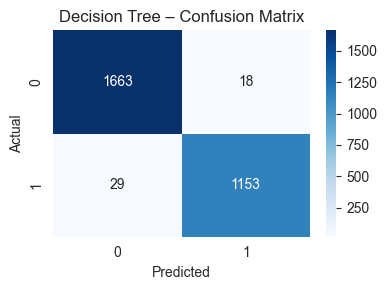

In [164]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Decision Tree – Confusion Matrix")
plt.tight_layout()
plt.show()


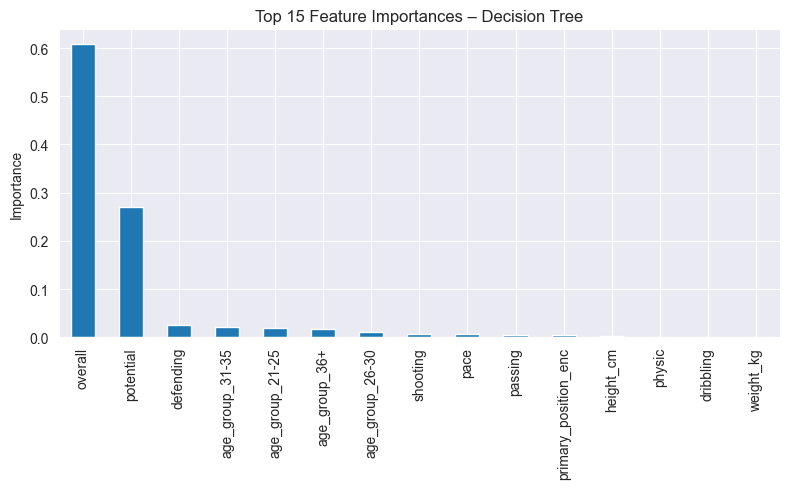

overall                 0.608334
potential               0.269404
defending               0.024590
age_group_31-35         0.021405
age_group_21-25         0.018807
age_group_36+           0.017705
age_group_26-30         0.010938
shooting                0.007319
pace                    0.005815
passing                 0.004106
primary_position_enc    0.003895
height_cm               0.002056
physic                  0.001413
dribbling               0.001342
weight_kg               0.001069
dtype: float64

In [165]:
dt_importances = pd.Series(
    dt_best.feature_importances_,
    index=features
).sort_values(ascending=False)

plt.figure(figsize=(8, 5))
dt_importances.head(15).plot(kind="bar")
plt.title("Top 15 Feature Importances – Decision Tree")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

dt_importances.head(15)


===========================================================================

In [166]:
rf_param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2"],
    "criterion": ["gini", "entropy"]
}


In [167]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.9814879497031086

In [168]:
grid_rf = GridSearchCV(rf, rf_param_grid, cv=3, return_train_score=False, n_jobs=-1)

grid_rf.fit(X_train, y_train)

,estimator,RandomForestC...ndom_state=42)
,param_grid,"{'criterion': ['gini', 'entropy'], 'max_depth': [None, 10, ...], 'max_features': ['sqrt', 'log2'], 'min_samples_leaf': [1, 2, ...], ...}"
,scoring,None
,n_jobs,-1
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,300


In [169]:
grid_rf.best_score_

np.float64(0.9843668501299953)

In [170]:
grid_rf.best_params_

{'criterion': 'entropy',
 'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 300}

In [171]:
rf_best = grid_rf.best_estimator_
rf_best

,n_estimators,300
,criterion,'entropy'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [172]:
y_pred = rf_best.predict(X_test)

results_df = pd.DataFrame({
    "actual": y_test.values,
    "predicted": y_pred
})

results_df.head(10)

,actual,predicted
0,1,1
1,0,0
2,0,0
3,1,1
4,0,0
5,1,1
6,1,1
7,1,1
8,1,1
9,0,0


In [173]:
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\nRandom Forest Evaluation")
print("-"*40)
print("Accuracy :", round(acc, 3))
print("Precision:", round(prec, 3))
print("Recall   :", round(rec, 3))
print("F1-score :", round(f1, 3))


Random Forest Evaluation
----------------------------------------
Accuracy : 0.981
Precision: 0.977
Recall   : 0.978
F1-score : 0.978


In [174]:
y_train_pred = rf_best.predict(X_train)

train_f1 = f1_score(y_train, y_train_pred)
test_f1 = f1_score(y_test, y_pred)

print("\nOverfitting Check")
print("-"*40)
print("Train F1:", round(train_f1, 3))
print("Test  F1:", round(test_f1, 3))


Overfitting Check
----------------------------------------
Train F1: 1.0
Test  F1: 0.978


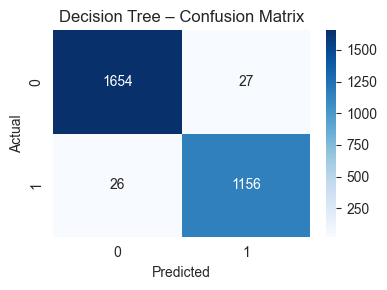

In [175]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Decision Tree – Confusion Matrix")
plt.tight_layout()
plt.show()

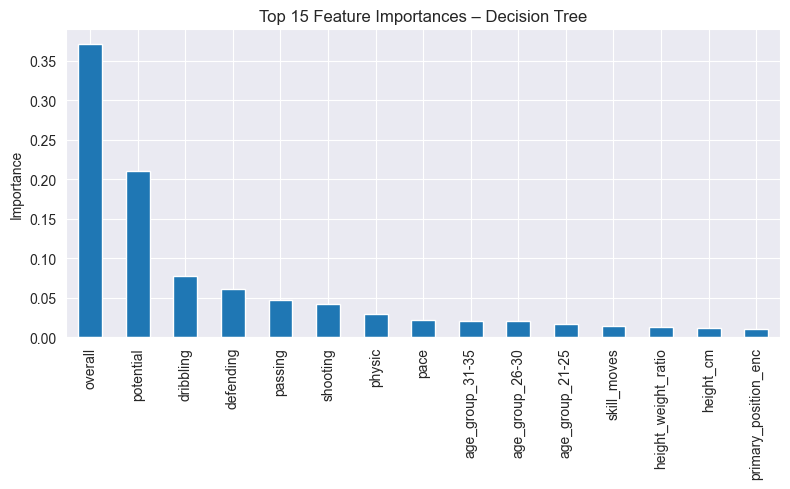

overall                 0.371022
potential               0.210901
dribbling               0.077640
defending               0.060801
passing                 0.046724
shooting                0.041980
physic                  0.028830
pace                    0.022143
age_group_31-35         0.020800
age_group_26-30         0.020757
age_group_21-25         0.016620
skill_moves             0.013727
height_weight_ratio     0.013411
height_cm               0.011496
primary_position_enc    0.011054
dtype: float64

In [176]:
dt_importances = pd.Series(
    rf_best.feature_importances_,
    index=features
).sort_values(ascending=False)

plt.figure(figsize=(8, 5))
dt_importances.head(15).plot(kind="bar")
plt.title("Top 15 Feature Importances – Decision Tree")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

dt_importances.head(15)

===========================================================================

In [177]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['rbf', 'linear'],
    'gamma': [0.001, 0.01, 0.1, 1]
}

In [178]:
svm = SVC(random_state=42)

svm.fit(X_train, y_train)
svm.score(X_test, y_test)

0.966468739084876

In [179]:
grid_svm = GridSearchCV(svm, param_grid, cv=3, return_train_score=False, n_jobs=-1)
grid_svm.fit(X_train, y_train)

,estimator,SVC(random_state=42)
,param_grid,"{'C': [0.1, 1, ...], 'gamma': [0.001, 0.01, ...], 'kernel': ['rbf', 'linear']}"
,scoring,None
,n_jobs,-1
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,C,100


In [180]:
grid_svm.best_score_

np.float64(0.9753713388575549)

In [181]:
grid_svm.best_params_

{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}

In [182]:
svm_best = grid_svm.best_estimator_
svm_best

,C,100
,kernel,'rbf'
,degree,3
,gamma,0.01
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [183]:
y_pred = svm_best.predict(X_test)

results_df = pd.DataFrame({
    "actual": y_test.values,
    "predicted": y_pred
})

results_df.head(10)

,actual,predicted
0,1,1
1,0,0
2,0,0
3,1,1
4,0,0
5,1,1
6,1,1
7,1,1
8,1,1
9,0,0


In [184]:
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\nSupport Vectore Machine Evaluation")
print("-"*40)
print("Accuracy :", round(acc, 3))
print("Precision:", round(prec, 3))
print("Recall   :", round(rec, 3))
print("F1-score :", round(f1, 3))


Support Vectore Machine Evaluation
----------------------------------------
Accuracy : 0.974
Precision: 0.968
Recall   : 0.969
F1-score : 0.968


In [185]:
y_train_pred = svm_best.predict(X_train)

train_f1 = f1_score(y_train, y_train_pred)
test_f1 = f1_score(y_test, y_pred)

print("\nOverfitting Check")
print("-"*40)
print("Train F1:", round(train_f1, 3))
print("Test  F1:", round(test_f1, 3))


Overfitting Check
----------------------------------------
Train F1: 0.984
Test  F1: 0.968


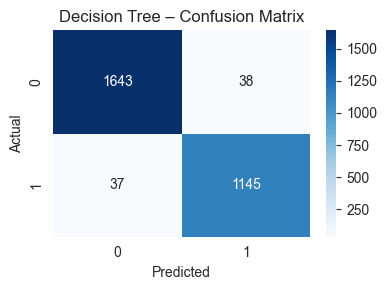

In [186]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Decision Tree – Confusion Matrix")
plt.tight_layout()
plt.show()

In [187]:
param_grid = {
    "n_neighbors": [2, 3, 5, 7, 9, 11, 15, 21],
    "weights": ["uniform", "distance"],
    "p": [1, 2],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
}

In [188]:
knn = KNeighborsClassifier(n_neighbors=3)

knn.fit(X_train, y_train)

knn.score(X_test, y_test)

0.899406217254628

In [189]:
knn_grid = GridSearchCV(knn, param_grid, cv=5, return_train_score=False, n_jobs=-1)
knn_grid.fit(X_train, y_train)

,estimator,KNeighborsCla...n_neighbors=3)
,param_grid,"{'algorithm': ['auto', 'ball_tree', ...], 'n_neighbors': [2, 3, ...], 'p': [1, 2], 'weights': ['uniform', 'distance']}"
,scoring,None
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_neighbors,21


In [190]:
knn_grid.best_params_

{'algorithm': 'auto', 'n_neighbors': 21, 'p': 1, 'weights': 'distance'}

In [191]:
knn_grid.best_score_

np.float64(0.9401746724890829)

In [192]:
knn_best = knn_grid.best_estimator_
knn_best

,n_neighbors,21
,weights,'distance'
,algorithm,'auto'
,leaf_size,30
,p,1
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [193]:
y_pred = knn_best.predict(X_test)

results_df_knn = pd.DataFrame({
    "actual": y_test.values,
    "predicted": y_pred
})

results_df_knn.head(10)


,actual,predicted
0,1,1
1,0,0
2,0,0
3,1,1
4,0,0
5,1,1
6,1,1
7,1,1
8,1,1
9,0,0


In [194]:
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\nK-Nearest Neighbors Evaluation")
print("-" * 40)
print("Accuracy :", round(acc, 3))
print("Precision:", round(prec, 3))
print("Recall   :", round(rec, 3))
print("F1-score :", round(f1, 3))



K-Nearest Neighbors Evaluation
----------------------------------------
Accuracy : 0.938
Precision: 0.934
Recall   : 0.915
F1-score : 0.924


In [195]:
y_train_pred = knn_best.predict(X_train)

train_f1 = f1_score(y_train, y_train_pred)
test_f1 = f1_score(y_test, y_pred)

print("\nOverfitting Check (KNN)")
print("-" * 40)
print("Train F1:", round(train_f1, 3))
print("Test  F1:", round(test_f1, 3))



Overfitting Check (KNN)
----------------------------------------
Train F1: 1.0
Test  F1: 0.924


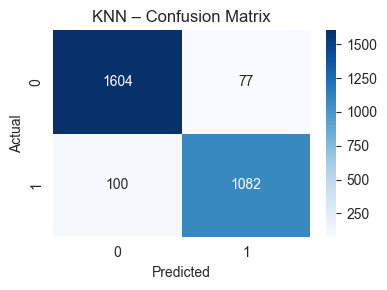

In [196]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("KNN – Confusion Matrix")
plt.tight_layout()
plt.show()


In [202]:
dt_cvs = cross_val_score(dt_best, X, y_clf, cv=10, n_jobs=-1, scoring='f1')
rf_cvs = cross_val_score(rf_best, X, y_clf, cv=10, n_jobs=-1, scoring='f1')
svm_cvs = cross_val_score(svm_best, X, y_clf, cv=10, n_jobs=-1, scoring='f1')
knn_cvs = cross_val_score(knn_best, X, y_clf, cv=10, n_jobs=-1, scoring='f1')

In [205]:
df = pd.DataFrame({
    "Decision Tree": dt_cvs,
    "Random Forest": rf_cvs,
    "Support Vector Machine": svm_cvs,
    "K Nearest Neighbors": knn_cvs
})
df

,Decision Tree,Random Forest,Support Vector Machine,K Nearest Neighbors
0,0.680092,0.680092,0.695294,0.711191
1,0.808511,0.845494,0.929755,0.859012
2,0.896393,0.893424,0.962480,0.899846
3,0.939910,0.962445,0.969900,0.931800
4,0.981034,0.977509,0.986278,0.967851
5,0.979275,0.982788,0.988879,0.982847
6,0.976623,0.961336,0.976623,0.950266
7,0.809668,0.809668,0.968586,0.876426
8,0.806876,0.816449,0.910434,0.803245
9,0.447368,0.065574,0.678611,0.483290


In [206]:
df_model_statistics = df.agg(['mean', 'min', 'max']).T
df_model_statistics

,mean,min,max
Decision Tree,0.832575,0.447368,0.981034
Random Forest,0.799478,0.065574,0.982788
Support Vector Machine,0.906684,0.678611,0.988879
K Nearest Neighbors,0.846578,0.483290,0.982847


In [207]:
print(df_model_statistics.values.max())
print(df_model_statistics['max'].idxmax())

0.9888793840889649
Support Vector Machine


In [208]:
print(df_model_statistics.values.min())
print(df_model_statistics['min'].idxmax())

0.06557377049180328
Support Vector Machine
